In [100]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='white')
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit, minimize
from sklearn.cluster import KMeans
from copy import deepcopy
import warnings

## Utilities

In [29]:
def invertFast(A, d):
    """
    given an array A of shape d x k and a d x 1 vector d, computes (A * A.T + diag(d)) ^{-1}
    Checked.
    """
    assert(A.shape[0] == d.shape[0])
    assert(d.shape[1] == 1)

    k = A.shape[1]
    A = np.array(A)
    d_vec = np.array(d)
    d_inv = np.array(1 / d_vec[:, 0])

    inv_d_squared = np.dot(np.atleast_2d(d_inv).T, np.atleast_2d(d_inv))
    M = np.diag(d_inv) - inv_d_squared * np.dot(np.dot(A, np.linalg.inv(np.eye(k, k) + np.dot(A.T, mult_diag(d_inv, A)))), A.T)

    return M


def mult_diag(d, mtx, left=True):
	"""
	Multiply a full matrix by a diagonal matrix.
	This function should always be faster than dot.
	Input:
	d -- 1D (N,) array (contains the diagonal elements)
	mtx -- 2D (N,N) array
	Returns:
	mult_diag(d, mts, left=True) == dot(diag(d), mtx)
	mult_diag(d, mts, left=False) == dot(mtx, diag(d))
	"""
	if left:
		return (d * mtx.T).T
	else:
		return d * mtx

def applyWoodburyIdentity(A_inv, B_inv, C):
	"""
	uses Woodbury identity to compute inverse of (A + C * B * C.T)
	"""
	A_inv = np.matrix(A_inv)
	B_inv = np.matrix(B_inv)
	C = np.matrix(C)

	A_inv_C = (A_inv * C)
	M = A_inv - A_inv_C * np.linalg.inv(B_inv + C.T * A_inv_C) * A_inv_C.T
	return M


def exp_decay(x, decay_coef):
    """
    squared exponential decay function.
    """
    return np.exp(-decay_coef * (x ** 2))

def decayCoefObjectiveFn(x, Y, EX2):
	"""
	Computes the objective function for terms involving lambda in the M-step.
	Checked.
	Input:
	x: value of lambda
	Y: the matrix of observed values
	EX2: the matrix of values of EX2 estimated in the E-step.
	Returns:
	obj: value of objective function
	grad: gradient
	"""
	with warnings.catch_warnings():
		warnings.simplefilter("ignore")

		y_squared = Y ** 2
		Y_is_zero = np.abs(Y) < 1e-6
		exp_Y_squared = np.exp(-x * y_squared)
		log_exp_Y = np.nan_to_num(np.log(1 - exp_Y_squared))
		exp_ratio = np.nan_to_num(exp_Y_squared / (1 - exp_Y_squared))
		obj = sum(sum(Y_is_zero * (-EX2 * x) + (1 - Y_is_zero) * log_exp_Y))
		grad = sum(sum(Y_is_zero * (-EX2) + (1 - Y_is_zero) * y_squared * exp_ratio))

		if (type(obj) is not np.float64) or (type(grad) is not np.float64):
			raise Exception("Unexpected behavior in optimizing decay coefficient lambda. Please contact emmap1@cs.stanford.edu.")
		if type(obj) is np.float64:
			obj = -np.array([obj])
		if type(grad) is np.float64:
			grad = -np.array([grad])

		return obj, grad

    
def computeMatrixInLastStep(A, zero_indices, sigmas, K, sigma_c, decay_coef, sigma_22_inv):
	"""
	Optimized matrix method for the E-step.
	This computes (1 + 2 * decay_coef * I_x * sigma_c) ^ {-1}
	zero_indices should have length D.
	"""
	A_0 = np.matrix(A[zero_indices, :])
	A_plus = np.matrix(A[~zero_indices, :])
	sigmas_0 = sigmas[zero_indices]

	E_xz = sigma_c[K:, :][:, :K]
	E_00_prime_inv = np.matrix(invertFast(A_0, sigmas_0 ** 2 + 1 / (2. * decay_coef)))
	E_plusplus_inv = sigma_22_inv
	E_0plus = A_0 * A_plus.T

	if (E_plusplus_inv.shape[0] == 0) or (E_plusplus_inv.shape[1] == 0):
		inv_matrix = (1 / (2. * decay_coef)) * E_00_prime_inv

	elif (A_0.shape[0] < A_0.shape[1]):
		inv_matrix = np.linalg.inv(2. * decay_coef * (np.linalg.inv(E_00_prime_inv) - E_0plus * E_plusplus_inv * E_0plus.T))

	else:
		b_inv = np.linalg.inv((np.matrix(A_0).T * E_00_prime_inv) * np.matrix(A_0))
		innermost_inverse = applyWoodburyIdentity(-E_plusplus_inv, b_inv, np.matrix(A_plus))
		inv_matrix = (1 / (2. * decay_coef)) * (E_00_prime_inv - (E_00_prime_inv * A_0) * (A_plus.T * innermost_inverse * A_plus) * (A_0.T * E_00_prime_inv))

	dim = len(sigma_c)
	M = np.zeros([dim, dim])
	M[:K, :K] = np.eye(K)
	M[K:, :K] = -2 * decay_coef * np.dot(inv_matrix, E_xz)
	M[K:, K:] = inv_matrix

	return np.array(M)
    
    
def calcConditionalDistribution(A, mus, sigmas, zero_indices, observed_values):
	"""
	Computes the distribution of X and Z conditional on the NONZERO values of Y. Matrix computations optimized.
	Input:
	A, mus, sigmas are parameters.
	zero_indices has length D and zero_indices[j] is zero iff Y[j] is zero.
	observed_values are the values of Y at the nonzero indices
	Output: various matrices used in the rest of the E-step.
	"""
	D, K = A.shape
	dim = D + K

	# mu_x and sigma_x here are the PRIOR DISTRIBUTIONS over [Z, X]
	mu_x = np.zeros([dim, 1])
	mu_x[K:dim, :] = mus
	augmentedA = np.matrix(np.zeros([dim, K]))
	augmentedA[:K, :] = np.eye(K)
	augmentedA[K:, :] = A
	mu_x = np.atleast_2d(mu_x)
	observed_values = np.atleast_2d(observed_values)

	if len(observed_values) == 1:
		observed_values = observed_values.transpose()

	mu_diff = np.matrix(np.atleast_2d(observed_values - mus[~zero_indices]))

	assert(mu_diff.shape[0] == len(observed_values) and mu_diff.shape[1] == 1)
	assert(len(zero_indices) == D)
	assert(zero_indices.sum() == D - len(observed_values))

	augmented_zero_indices = np.array([True for a in range(K)] + list(zero_indices))

	# 1 denotes the zero entries, 2 denotes the nonzero entries
	augmentedA_0 = augmentedA[augmented_zero_indices, :]
	augmentedA_plus = augmentedA[~augmented_zero_indices, :]
	sigma_11 = augmentedA_0 * augmentedA_0.T
	sigma_11[K:, K:] = sigma_11[K:, K:] + np.diag(sigmas[zero_indices][:, 0] ** 2)
	augmented_D = np.array([0 for i in range(K)] + list(sigmas[zero_indices][:, 0] ** 2))

	if len(observed_values) == 0:
		sigma_x = augmentedA * augmentedA.T
		sigma_x[K:, K:] = sigma_x[K:, K:] + np.diag(sigmas[zero_indices][:, 0] ** 2)
		return mu_x, sigma_x, augmentedA_0, augmentedA_plus, augmented_D, np.array([[]])

	sigma_22_inv = np.matrix(invertFast(A[~zero_indices, :], sigmas[~zero_indices] ** 2))
	mu_0 = mu_x[augmented_zero_indices, :] + augmentedA_0 * (augmentedA_plus.T * (sigma_22_inv * mu_diff))
	sigma_0 = sigma_11 - augmentedA_0 * (augmentedA_plus.T * sigma_22_inv * augmentedA_plus) * augmentedA_0.T

	assert((mu_0.shape[0] == zero_indices.sum() + K) and (mu_0.shape[1] == 1))
	assert(sigma_0.shape[0] == zero_indices.sum() + K and sigma_0.shape[1] == zero_indices.sum() + K)

	return np.array(mu_0), np.array(sigma_0), augmentedA_0, augmentedA_plus, augmented_D, sigma_22_inv

## Fit model

In [27]:
from sklearn.decomposition import FactorAnalysis

def initializeParams(Y, K, singleSigma=False, makePlot=False):
	"""
	initializes parameters using a standard factor analysis model (on imputed data) + exponential curve fitting.
	Checked.
	Input:
	Y: data matrix, n_samples x n_genes
	K: number of latent components
	singleSigma: uses only a single sigma as opposed to a different sigma for every gene
	makePlot: makes a mu - p_0 plot and shows the decaying exponential fit.
	Returns:
	A, mus, sigmas, decay_coef: initialized model parameters.
	"""

	N, D = Y.shape
	model = FactorAnalysis(n_components=K)
	zeroedY = deepcopy(Y)
	mus = np.zeros([D, 1])

	for j in range(D):
		non_zero_idxs = np.abs(Y[:, j]) > 1e-6
		mus[j] = zeroedY[:, j].mean()
		zeroedY[:, j] = zeroedY[:, j] - mus[j]

	model.fit(zeroedY)

	A = model.components_.transpose()
	sigmas = np.atleast_2d(np.sqrt(model.noise_variance_)).transpose()
	if singleSigma:
		sigmas = np.mean(sigmas) * np.ones(sigmas.shape)

	# Now fit decay coefficient
	means = []
	ps = []
	for j in range(D):
		non_zero_idxs = np.abs(Y[:, j]) > 1e-6
		means.append(Y[non_zero_idxs, j].mean())
		ps.append(1 - non_zero_idxs.mean())

	decay_coef, pcov = curve_fit(exp_decay, means, ps, p0=.05)
	decay_coef = decay_coef[0]

	mse = np.mean(np.abs(ps - np.exp(-decay_coef * (np.array(means) ** 2))))

	if (mse > 0) and makePlot:
		from matplotlib.pyplot import figure, scatter, plot, title, show
		figure()
		scatter(means, ps)
		plot(np.arange(min(means), max(means), .1), np.exp(-decay_coef * (np.arange(min(means), max(means), .1) ** 2)))
		title('Decay Coef is %2.3f; MSE is %2.3f' % (decay_coef, mse))
		show()

	return A, mus, sigmas, decay_coef



In [23]:
def Mstep(Y, EZ, EZZT, EX, EXZ, EX2, oldA, old_mus, old_sigmas, old_decay_coef, singleSigma=False):
	"""
	estimates parameters given the expectations computed in the E-step.
	Input:
	Y: observed values.
	EZ, EZZT, EX, EXZ, EX2: expectations of latent variables computed in E-step.
	oldA, old_mus, old_sigmas, old_decay_coef: old parameters.
	singleSigma: only estimates one sigma as opposed to sigma_j for all j.
	Returns:
	A, mus, sigmas, decay_coef: new values of parameters.
	"""
	assert(len(Y) == len(EZ))
	N, D = Y.shape
	N, K = EZ.shape

	# First estimate A and mu
	A = np.zeros([D, K])
	mus = np.zeros([D, 1])
	sigmas = np.zeros([D, 1])
	Y_is_zero = np.abs(Y) < 1e-6

	# Make B, which is the same for all J.
	B = np.eye(K + 1)
	for k1 in range(K):
		for k2 in range(K):
			B[k1][k2] = sum(EZZT[:, k1, k2])
		B[K, :K] = EZ.sum(axis=0)
		B[:K, K] = EZ.sum(axis=0)

	B[K, K] = N

	tiled_EZ = np.tile(np.resize(EZ, [N, 1, K]), [1, D, 1])
	tiled_Y = np.tile(np.resize(Y, [N, D, 1]), [1, 1, K])
	tiled_Y_is_zero = np.tile(np.resize(Y_is_zero, [N, D, 1]), [1, 1, K])

	c = np.zeros([K + 1, D])
	c[K, :] += (Y_is_zero * EX + (1 - Y_is_zero) * Y).sum(axis=0)
	c[:K, :] = (tiled_Y_is_zero * EXZ + (1 - tiled_Y_is_zero) * tiled_Y * tiled_EZ).sum(axis=0).transpose()

	solution = np.dot(np.linalg.inv(B), c)
	A = solution[:K, :].transpose()
	mus = np.atleast_2d(solution[K, :]).transpose()

	# Then optimize sigma
	EXM = np.zeros([N, D])  # have to figure these out  after updating mu.
	EM = np.zeros([N, D])
	EM2 = np.zeros([N, D])

	tiled_mus = np.tile(mus.transpose(), [N, 1])
	tiled_A = np.tile(np.resize(A, [1, D, K]), [N, 1, 1])

	EXM = (tiled_A * EXZ).sum(axis=2) + tiled_mus * EX
	test_sum = (tiled_A * tiled_EZ).sum(axis=2)
	A_product = np.tile(np.reshape(A, [1, D, K]), [K, 1, 1]) * (np.tile(np.reshape(A, [1, D, K]), [K, 1, 1]).T)

	for i in range(N):
		EM[i, :] = (np.dot(A, EZ[i, :].transpose()) + mus.transpose())  # this should be correct
		EZZT_tiled = np.tile(np.reshape(EZZT[i, :, :], [K, 1, K]), [1, D, 1])
		ezzt_sum = (EZZT_tiled * A_product).sum(axis=2).sum(axis=0)
		EM2[i, :] = ezzt_sum + 2 * test_sum[i, :] * tiled_mus[i, :] + tiled_mus[i, :] ** 2

	sigmas = (Y_is_zero * (EX2 - 2 * EXM + EM2) + (1 - Y_is_zero) * (Y ** 2 - 2 * Y * EM + EM2)).sum(axis=0)
	sigmas = np.atleast_2d(np.sqrt(sigmas / N)).transpose()

	if singleSigma:
		sigmas = np.mean(sigmas) * np.ones(sigmas.shape)

	decay_coef = minimize(lambda x: decayCoefObjectiveFn(x, Y, EX2), old_decay_coef, jac=True, bounds=[[1e-8, np.inf]])
	decay_coef = decay_coef.x[0]

	return A, mus, sigmas, decay_coef

In [24]:
def Estep(Y, A, mus, sigmas, decay_coef):
	"""
	estimates the requisite latent expectations in the E-step.
	Checked.
	Input:
	Y: observed data.
	A, mus, sigmas, decay_coef: parameters.
	Returns:
	EZ, EZZT, EX, EXZ, EX2: latent expectations.
	"""
	assert(len(Y[0]) == len(A))

	N, D = Y.shape
	D, K = A.shape
	assert((sigmas.shape[0] == D) and (sigmas.shape[1] == 1))
	assert((mus.shape[0] == D) and (mus.shape[1] == 1))

	EX = np.zeros([N, D])
	EXZ = np.zeros([N, D, K])  # this is a 3D tensor.
	EX2 = np.zeros([N, D])
	EZ = np.zeros([N, K])
	EZZT = np.zeros([N, K, K])

	for i in range(N):
		# compute P(Z, X_0 | Y) following three step formula.
		# 1. compute P(Z, X_0)
		Y_i = Y[i, :]
		Y_is_zero = np.abs(Y_i) < 1e-6
		dim = K + D  # this is dimension of matrix

		# 2. compute P(Z, X_0 | Y_+)
		mu_c, sigma_c, augmentedA_0, augmentedA_plus, augmented_D, sigma_22_inv = calcConditionalDistribution(A, mus, sigmas, np.array([np.abs(Y_i[j]) < 1e-6 for j in range(D)]), Y_i[~Y_is_zero])

		# 3. compute P(Z, X_0 | Y_+, Y_0)
		dim = len(sigma_c)
		matrixToInvert = computeMatrixInLastStep(A, np.abs(Y[i, :]) < 1e-6, sigmas, K, sigma_c, decay_coef, sigma_22_inv)

		if (Y_is_zero).sum() < D:
			magical_matrix = 2 * decay_coef * (mult_diag(augmented_D, matrixToInvert) + augmentedA_0 * (np.eye(K) - augmentedA_plus.T * sigma_22_inv * augmentedA_plus) * (augmentedA_0.T * matrixToInvert))
		else:
			magical_matrix = 2 * decay_coef * (mult_diag(augmented_D, matrixToInvert) + augmentedA_0 * (augmentedA_0.T * matrixToInvert))
		magical_matrix[:, :K] = 0

		if (Y_is_zero).sum() < D:
			sigma_xz = np.array(sigma_c - mult_diag(augmented_D, np.array(magical_matrix), left=False) - (magical_matrix * augmentedA_0) * ((np.eye(K) - augmentedA_plus.T * sigma_22_inv * augmentedA_plus) * augmentedA_0.T))
		else:
			sigma_xz = np.array(sigma_c - mult_diag(augmented_D, np.array(magical_matrix), left=False) - (magical_matrix * augmentedA_0) * augmentedA_0.T)

		mu_xz = np.array(np.matrix(np.eye(dim) - magical_matrix) * np.matrix(mu_c))

		EZ[i, :] = mu_xz[:K, 0]
		EX[i, Y_is_zero] = mu_xz[K:, 0]
		EX2[i, Y_is_zero] = mu_xz[K:, 0] ** 2 + np.diag(sigma_xz[K:, K:])
		EZZT[i, :, :] = np.dot(np.atleast_2d(mu_xz[:K, :]), np.atleast_2d(mu_xz[:K, :].transpose())) + sigma_xz[:K, :K]
		EXZ[i, Y_is_zero, :] = np.dot(mu_xz[K:], mu_xz[:K].transpose()) + sigma_xz[K:, :K]

	return EZ, EZZT, EX, EXZ, EX2


In [39]:
def fitModel(Y, K, singleSigma=False):
	"""
	fits the model to data.
	Input:
	Y: data matrix, n_samples x n_genes
	K: number of latent components
	singleSigma: if True, fit only a single variance parameter (zero-inflated PPCA) rather than a different one for every gene (zero-inflated factor analysis).
	Returns:
	EZ: the estimated positions in the latent space, n_samples x K
	params: a dictionary of model parameters. Throughout, we refer to lambda as "decay_coef".
	"""
	Y = deepcopy(Y)
	N, D = Y.shape

	print('Running zero-inflated factor analysis with N = %i, D = %i, K = %i' % (N, D, K))

	# Initialize the parameters
	np.random.seed(23)
	A, mus, sigmas, decay_coef = initializeParams(Y, K, singleSigma=singleSigma)

	max_iter = 100
	param_change_thresh = 1e-2
	n_iter = 0

	while n_iter < max_iter:

		EZ, EZZT, EX, EXZ, EX2 = Estep(Y, A, mus, sigmas, decay_coef)
		new_A, new_mus, new_sigmas, new_decay_coef = Mstep(Y, EZ, EZZT, EX, EXZ, EX2, A, mus, sigmas, decay_coef, singleSigma=singleSigma)

		paramsNotChanging = True
		max_param_change = 0

		for new, old in [[new_A, A], [new_mus, mus], [new_sigmas, sigmas], [new_decay_coef, decay_coef]]:
			rel_param_change = np.mean(np.abs(new - old)) / np.mean(np.abs(new))

			if rel_param_change > max_param_change:
				max_param_change = rel_param_change

			if rel_param_change > param_change_thresh:
				paramsNotChanging = False
				break

		A = new_A
		mus = new_mus
		sigmas = new_sigmas
		decay_coef = new_decay_coef

		if paramsNotChanging:
			print('Param change below threshold %2.3e after %i iterations' % (param_change_thresh, n_iter))
			break

		if n_iter >= max_iter:
			print('Maximum number of iterations reached; terminating loop')
		n_iter += 1

	EZ, EZZT, EX, EXZ, EX2 = Estep(Y, A, mus, sigmas, decay_coef)
	params = {'A': A, 'mus': mus, 'sigmas': sigmas, 'decay_coef': decay_coef}

	return EZ, EX, params


## Simulate Data

In [66]:
import random

random.seed(123)
np.random.seed(123)

MSE = {'A':[],'mu':[],'sigma':[],'decay_coef':[]}

for iter in range(200):
    n = 200
    d = 20
    k = 2
    sigma = .3
    n_clusters = 3
    decay_coef = .1

    mu = 3
    range_from_value = .1

    Z = np.zeros([k, n])
    cluster_ids = np.array([random.choice(range(n_clusters)) for i in range(n)])

    for id in list(set(cluster_ids)):
        idxs = cluster_ids == id
        cluster_mu = (np.random.random([k]) - .5) * 5
        Z[:, idxs] = np.random.multivariate_normal(mean=cluster_mu, cov=.05 * np.eye(k), size=idxs.sum()).transpose()

    A = np.random.random([d, k]) - .5
    mu = np.array([(np.random.uniform() * 0.2 + 0.9) * mu for i in range(d)])
    sigmas = np.array([(np.random.uniform() * 0.2 + 0.9) * sigma for i in range(d)])
    noise = np.zeros([d, n])

    for j in range(d):
        noise[j, :] = mu[j] + np.random.normal(loc=0, scale=sigmas[j], size=n)

    X = (np.dot(A, Z) + noise).transpose()
    Y = deepcopy(X)
    Y[Y < 0] = 0
    rand_matrix = np.random.random(Y.shape)

    cutoff = np.exp(-decay_coef * (Y ** 2))
    zero_mask = rand_matrix < cutoff
    Y[zero_mask] = 0
    
    print('Iter: %d  Fraction of zeros: %2.3f; decay coef: %2.3f' % (iter, (Y == 0).mean(), decay_coef))

    Z = Z.transpose()
    ids = cluster_ids

    # fit ZIFA
    EZ, EX, params = fitModel(Y, k, False)
    MSE['A'].append(np.mean((params['A'] - A)**2))
    MSE['mu'].append(np.mean((params['mus'] - mu.T)**2))
    MSE['sigma'].append(np.mean((params['sigmas'] - sigmas.T)**2))
    MSE['decay_coef'].append(np.mean((params['decay_coef'] - decay_coef)**2))

Iter: 0  Fraction of zeros: 0.419; decay coef: 0.100
Running zero-inflated factor analysis with N = 200, D = 20, K = 2
Param change below threshold 1.000e-02 after 37 iterations
Iter: 1  Fraction of zeros: 0.446; decay coef: 0.100
Running zero-inflated factor analysis with N = 200, D = 20, K = 2
Param change below threshold 1.000e-02 after 16 iterations
Iter: 2  Fraction of zeros: 0.419; decay coef: 0.100
Running zero-inflated factor analysis with N = 200, D = 20, K = 2
Param change below threshold 1.000e-02 after 16 iterations
Iter: 3  Fraction of zeros: 0.424; decay coef: 0.100
Running zero-inflated factor analysis with N = 200, D = 20, K = 2
Param change below threshold 1.000e-02 after 17 iterations
Iter: 4  Fraction of zeros: 0.459; decay coef: 0.100
Running zero-inflated factor analysis with N = 200, D = 20, K = 2
Param change below threshold 1.000e-02 after 19 iterations
Iter: 5  Fraction of zeros: 0.443; decay coef: 0.100
Running zero-inflated factor analysis with N = 200, D = 2

Param change below threshold 1.000e-02 after 18 iterations
Iter: 47  Fraction of zeros: 0.440; decay coef: 0.100
Running zero-inflated factor analysis with N = 200, D = 20, K = 2
Param change below threshold 1.000e-02 after 16 iterations
Iter: 48  Fraction of zeros: 0.464; decay coef: 0.100
Running zero-inflated factor analysis with N = 200, D = 20, K = 2
Param change below threshold 1.000e-02 after 20 iterations
Iter: 49  Fraction of zeros: 0.410; decay coef: 0.100
Running zero-inflated factor analysis with N = 200, D = 20, K = 2
Param change below threshold 1.000e-02 after 16 iterations
Iter: 50  Fraction of zeros: 0.448; decay coef: 0.100
Running zero-inflated factor analysis with N = 200, D = 20, K = 2
Param change below threshold 1.000e-02 after 18 iterations
Iter: 51  Fraction of zeros: 0.470; decay coef: 0.100
Running zero-inflated factor analysis with N = 200, D = 20, K = 2
Param change below threshold 1.000e-02 after 20 iterations
Iter: 52  Fraction of zeros: 0.454; decay coef

Param change below threshold 1.000e-02 after 25 iterations
Iter: 93  Fraction of zeros: 0.422; decay coef: 0.100
Running zero-inflated factor analysis with N = 200, D = 20, K = 2
Param change below threshold 1.000e-02 after 22 iterations
Iter: 94  Fraction of zeros: 0.407; decay coef: 0.100
Running zero-inflated factor analysis with N = 200, D = 20, K = 2
Param change below threshold 1.000e-02 after 16 iterations
Iter: 95  Fraction of zeros: 0.428; decay coef: 0.100
Running zero-inflated factor analysis with N = 200, D = 20, K = 2
Param change below threshold 1.000e-02 after 17 iterations
Iter: 96  Fraction of zeros: 0.443; decay coef: 0.100
Running zero-inflated factor analysis with N = 200, D = 20, K = 2
Param change below threshold 1.000e-02 after 16 iterations
Iter: 97  Fraction of zeros: 0.436; decay coef: 0.100
Running zero-inflated factor analysis with N = 200, D = 20, K = 2
Param change below threshold 1.000e-02 after 17 iterations
Iter: 98  Fraction of zeros: 0.436; decay coef

Param change below threshold 1.000e-02 after 16 iterations
Iter: 139  Fraction of zeros: 0.419; decay coef: 0.100
Running zero-inflated factor analysis with N = 200, D = 20, K = 2
Param change below threshold 1.000e-02 after 17 iterations
Iter: 140  Fraction of zeros: 0.462; decay coef: 0.100
Running zero-inflated factor analysis with N = 200, D = 20, K = 2
Param change below threshold 1.000e-02 after 19 iterations
Iter: 141  Fraction of zeros: 0.464; decay coef: 0.100
Running zero-inflated factor analysis with N = 200, D = 20, K = 2
Param change below threshold 1.000e-02 after 24 iterations
Iter: 142  Fraction of zeros: 0.443; decay coef: 0.100
Running zero-inflated factor analysis with N = 200, D = 20, K = 2
Param change below threshold 1.000e-02 after 16 iterations
Iter: 143  Fraction of zeros: 0.449; decay coef: 0.100
Running zero-inflated factor analysis with N = 200, D = 20, K = 2
Param change below threshold 1.000e-02 after 17 iterations
Iter: 144  Fraction of zeros: 0.439; deca

Param change below threshold 1.000e-02 after 15 iterations
Iter: 185  Fraction of zeros: 0.431; decay coef: 0.100
Running zero-inflated factor analysis with N = 200, D = 20, K = 2
Param change below threshold 1.000e-02 after 16 iterations
Iter: 186  Fraction of zeros: 0.451; decay coef: 0.100
Running zero-inflated factor analysis with N = 200, D = 20, K = 2
Param change below threshold 1.000e-02 after 17 iterations
Iter: 187  Fraction of zeros: 0.419; decay coef: 0.100
Running zero-inflated factor analysis with N = 200, D = 20, K = 2
Param change below threshold 1.000e-02 after 16 iterations
Iter: 188  Fraction of zeros: 0.429; decay coef: 0.100
Running zero-inflated factor analysis with N = 200, D = 20, K = 2
Param change below threshold 1.000e-02 after 16 iterations
Iter: 189  Fraction of zeros: 0.421; decay coef: 0.100
Running zero-inflated factor analysis with N = 200, D = 20, K = 2
Param change below threshold 1.000e-02 after 16 iterations
Iter: 190  Fraction of zeros: 0.444; deca

{'boxes': [<matplotlib.lines.Line2D at 0x7f7acc3d9b38>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7acc3d25c0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f7acc3bd080>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f7acc3d2cc0>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f7acc3d9e80>,
  <matplotlib.lines.Line2D at 0x7f7acc3bdb00>]}

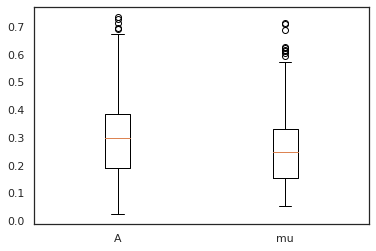

In [140]:
plt.boxplot([MSE['A'],MSE['mu']],labels=['A','mu'])

{'boxes': [<matplotlib.lines.Line2D at 0x7f7acc38d358>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7acc3929b0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f7acc38f470>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f7acc38f0f0>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f7acc3922b0>,
  <matplotlib.lines.Line2D at 0x7f7acc38fef0>]}

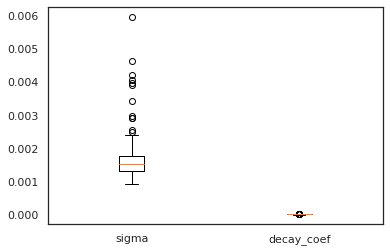

In [141]:
plt.boxplot([MSE['sigma'],MSE['decay_coef']],labels=['sigma','decay_coef'])

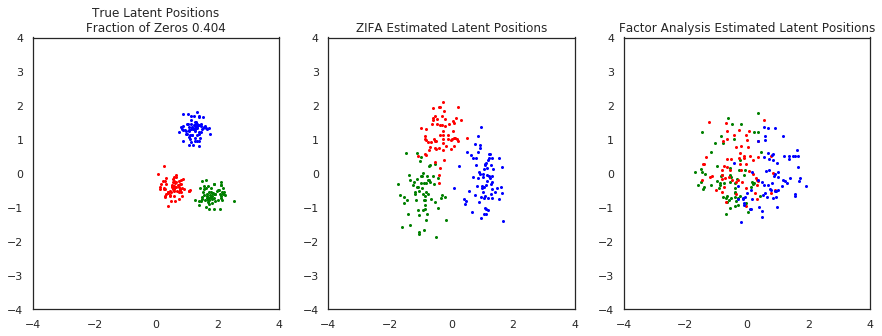

In [42]:
colors = ['red', 'blue', 'green']
cluster_ids = sorted(list(set(ids)))
model = FactorAnalysis(n_components=k)
factor_analysis_Zhat = model.fit_transform(Y)

plt.figure(figsize=[15, 5])

plt.subplot(131)
for id in cluster_ids:
    plt.scatter(Z[ids == id, 0], Z[ids == id, 1], color=colors[id - 1], s=4)
    plt.title('True Latent Positions\nFraction of Zeros %2.3f' % (Y == 0).mean())
    plt.xlim([-4, 4])
    plt.ylim([-4, 4])

plt.subplot(132)
for id in cluster_ids:
    plt.scatter(EZ[ids == id, 0], EZ[ids == id, 1], color=colors[id - 1], s=4)
    plt.xlim([-4, 4])
    plt.ylim([-4, 4])
    plt.title('ZIFA Estimated Latent Positions')
    # title(titles[method])

plt.subplot(133)
for id in cluster_ids:
    plt.scatter(factor_analysis_Zhat[ids == id, 0], factor_analysis_Zhat[ids == id, 1], color = colors[id - 1], s = 4)
    plt.xlim([-4, 4])
    plt.ylim([-4, 4])
    plt.title('Factor Analysis Estimated Latent Positions')

plt.show()

## Real data

In [85]:
data = np.loadtxt('./CORTEX data/gene_expression.txt')
EZ, EX, params = fitModel(data, K=10)

Running zero-inflated factor analysis with N = 3005, D = 558, K = 10
Param change below threshold 1.000e-02 after 5 iterations


In [86]:
from sklearn.cluster import KMeans
Km = 7
kmeans = KMeans(n_clusters = 7, random_state = 1234).fit(EZ)

In [87]:
kmeans.labels_
kmeans_classes = ['0','1','2','3','4','5','6']
true_labels = np.loadtxt('CORTEX data/labels.txt').reshape([-1])
classes = ['astrocytes_ependymal','endothelial-mural','interneurons','microglia',
            'oligodendrocytes','pyramidal CA1','pyramidal SS']

In [95]:
true_labels.shape

(3005,)

In [96]:
import umap.umap_ as umap
embedding = umap.UMAP().fit_transform(EZ)

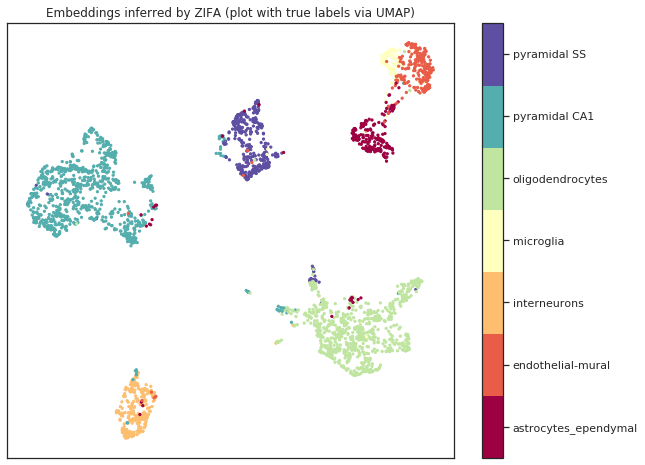

In [97]:
fig, ax = plt.subplots(1, figsize=(10, 8))
plt.scatter(*embedding.T, s=5.0, c=true_labels, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(8)-0.5)
cbar.set_ticks(np.arange(7))
cbar.set_ticklabels(classes)
plt.title('Embeddings inferred by ZIFA (plot with true labels via UMAP)');

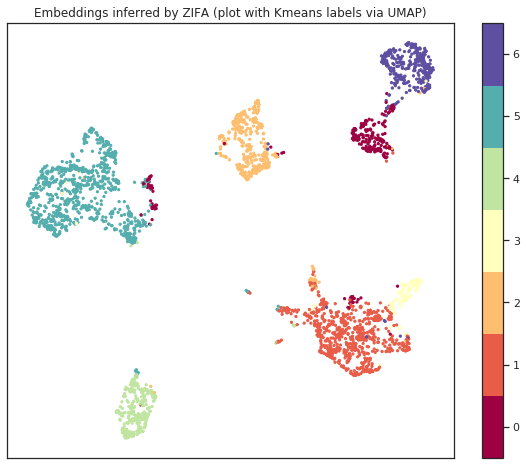

In [98]:
fig, ax = plt.subplots(1, figsize=(10, 8))
plt.scatter(*embedding.T, s=5.0, c=kmeans.labels_, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(8)-0.5)
cbar.set_ticks(np.arange(7))
cbar.set_ticklabels(kmeans_classes)
plt.title('Embeddings inferred by ZIFA (plot with Kmeans labels via UMAP)');

## amortized variational inference

In [112]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [119]:
device = torch.device("cuda:3")
Y_zero = torch.tensor((data == 0)*1.0, requires_grad = False).to(device)
Y_pos  = torch.tensor((data != 0)*1.0, requires_grad = False).to(device)
Y = torch.from_numpy(data).to(device).type(torch.float)
N = Y.shape[0]
D = Y.shape[1]
K = 10

In [120]:
Y.shape

torch.Size([3005, 558])

In [133]:
import pdb

class Net_Infer(nn.Module):
    def __init__(self, N, D, K):
        super(Net_Infer, self).__init__()
        self.N = N
        self.D = D
        self.K = K
        self.fc_share = nn.Sequential(
                        nn.Linear(self.D, 1024),
                        nn.ReLU(),
                        nn.Linear(1024, 1024),
                        nn.ReLU())
        
        self.fc_x_mu    = nn.Linear(1024, self.D)
        self.fc_x_sigma = nn.Linear(1024, self.D)
        
        self.fc_z_mu    = nn.Linear(1024, self.K)
        self.fc_z_sigma = nn.Linear(1024, self.K)
        
        self.fc_z_x = nn.Linear(self.K, self.D)
        
        self.sigma_logit = nn.Parameter(torch.Tensor(self.D).fill_(0))
        self.lam_logit = nn.Parameter(torch.Tensor(1).fill_(0))

    def forward(self, y):
        
        out_share = self.fc_share(y)

        x_mu    = self.fc_x_mu(out_share)
        x_sigma = self.fc_x_sigma(out_share)
        x_sigma = torch.exp(x_sigma)
        
        z_mu    = self.fc_z_mu(out_share)
        z_sigma = self.fc_z_sigma(out_share)
        z_sigma = torch.exp(z_sigma)
        
        x = x_mu + x_sigma * (torch.randn(self.N, self.D).to(device))
        z = z_mu + z_sigma * (torch.randn(self.N, self.K).to(device))
        
        x_tude = self.fc_z_x(z)
        
        sigma = torch.exp(self.sigma_logit)
        sigma = torch.reshape(sigma, (1,self.D))
        lam = torch.exp(self.lam_logit)
        
        return x_mu, x_sigma, z_mu, z_sigma, x, z, x_tude, sigma, lam

    
def ELBO_loss(X, X_sigma, Y, Z, Z_sigma, Y_zero, Y_pos, Xtude, sigma, lam):
    
    elbo_logcllz = - 0.5*torch.sum(Z**2)
    elbo_logcll0 = torch.sum((-(X-Xtude)**2/2/(sigma**2) - torch.log(sigma+1e-8) - lam*(X**2)) * Y_zero)
    elbo_logcll1 = torch.sum((-(Y-Xtude)**2/2/(sigma**2) - torch.log(sigma+1e-8) + \
                              torch.log(1-torch.exp(-lam*(Y**2))+1e-8)) * (Y_pos))
    
    elbo_entropy_x = torch.sum((torch.log(X_sigma+1e-8)) * Y_zero)
    elbo_entropy_z = torch.sum(torch.log(Z_sigma+1e-8))
    
    elbo = elbo_logcllz + elbo_logcll0 + elbo_logcll1 + elbo_entropy_x + elbo_entropy_z
    
    return elbo



In [135]:
model = Net_Infer(N, D, K).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
iter_max = 4000
model.train()
ELBO_list = []
for iter in range(iter_max):
    optimizer.zero_grad()
    x_mu, x_sigma, z_mu, z_sigma, x, z, x_tude, sigma, lam = model(Y)
    elbo = ELBO_loss(x, x_sigma, Y, z, z_sigma, Y_zero, Y_pos, x_tude, sigma, lam)
    loss = - elbo / N
    loss.backward()
    optimizer.step()
    
    ELBO_list.append(elbo / N)
    
    if iter%100 == 0:
        print('iter: %d, elbo: %3f'%(iter, -loss.cpu().data.numpy()))
        

iter: 0, elbo: -1499.493318
iter: 100, elbo: -536.561343
iter: 200, elbo: -446.002013
iter: 300, elbo: -401.999118
iter: 400, elbo: -372.338815
iter: 500, elbo: -350.736624
iter: 600, elbo: -328.438365
iter: 700, elbo: -309.598366
iter: 800, elbo: -289.417992
iter: 900, elbo: -273.097653
iter: 1000, elbo: -259.211106
iter: 1100, elbo: -248.276409
iter: 1200, elbo: -237.854962
iter: 1300, elbo: -230.161876
iter: 1400, elbo: -222.635802
iter: 1500, elbo: -217.116731
iter: 1600, elbo: -213.118375
iter: 1700, elbo: -207.523166
iter: 1800, elbo: -204.263716
iter: 1900, elbo: -200.275622
iter: 2000, elbo: -197.071913
iter: 2100, elbo: -194.716427
iter: 2200, elbo: -192.376281
iter: 2300, elbo: -191.472404
iter: 2400, elbo: -188.971531
iter: 2500, elbo: -187.198769
iter: 2600, elbo: -187.188960
iter: 2700, elbo: -186.260258
iter: 2800, elbo: -185.316396
iter: 2900, elbo: -183.655230
iter: 3000, elbo: -182.907848
iter: 3100, elbo: -182.715908
iter: 3200, elbo: -181.970816
iter: 3300, elbo: -18

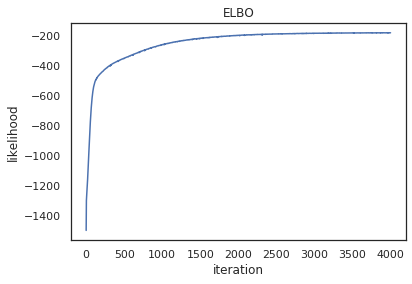

In [143]:
plt.figure()
plt.plot(np.arange(len(ELBO_list)), ELBO_list)
plt.title("ELBO")
plt.ylabel('likelihood')
plt.xlabel('iteration')
plt.show()

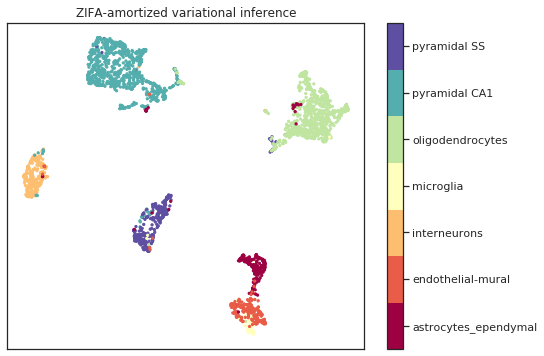

In [138]:
#z_mu = z_mu.cpu().data.numpy()
embedding = umap.UMAP().fit_transform(z_mu)
fig, ax = plt.subplots(1, figsize=(8, 6))
plt.scatter(*embedding.T, s=5.0, c=true_labels, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(8)-0.5)
cbar.set_ticks(np.arange(7))
cbar.set_ticklabels(classes)
plt.title('ZIFA-amortized variational inference');